In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def calculate_backtest_metrics(df, commission_rate=0.0003):
    """
    计算回测指标的核心函数
    :param df: 包含交易数据的DataFrame（必须包含trading_date, ts, lastPrice, pos, cost字段）
    :param commission_rate: 手续费率（默认万三）
    :return: 返回指标字典和绘图数据
    """
    # 复制数据避免修改原始数据
    data = df.copy()
    
    # 1. 计算基础指标
    data['pnl'] = 0.0  # 单笔盈亏
    data['commission'] = 0.0  # 单笔手续费
    data['trade_duration'] = 0  # 持仓时间（秒）
    
    # 标记交易信号变化点
    data['pos_chg'] = data['pos'].diff().fillna(0).abs()
    
    # 2. 计算交易相关指标
    open_trades = []
    trade_records = []
    current_trade = None
    
    for idx, row in data.iterrows():
        # 开仓逻辑（从0到1或-1）
        if row['pos_chg'] > 0 and pd.notna(row['cost']):
            if current_trade is None:
                current_trade = {
                    'open_date': row['trading_date'],
                    'open_time': row['ts'],
                    'open_price': row['cost'],
                    'direction': row['pos'],
                    'volume': 1,  # 假设每笔交易1手
                    'commission': abs(row['cost'] * commission_rate)
                }
        
        # 持仓中计算浮动盈亏
        elif current_trade is not None:
            current_pnl = (row['lastPrice'] - current_trade['open_price']) * current_trade['direction']
            data.at[idx, 'pnl'] = current_pnl
            data.at[idx, 'commission'] = current_trade['commission']
            
            # 平仓逻辑（仓位归零）
            if row['pos'] == 0 and pd.isna(row['cost']):
                trade_duration = (pd.to_datetime(row['trading_date'] + ' ' + row['ts']) - 
                                 pd.to_datetime(current_trade['open_date'] + ' ' + current_trade['open_time'])).total_seconds()
                
                realized_pnl = (row['lastPrice'] - current_trade['open_price']) * current_trade['direction']
                
                trade_records.append({
                    **current_trade,
                    'close_date': row['trading_date'],
                    'close_time': row['ts'],
                    'close_price': row['lastPrice'],
                    'realized_pnl': realized_pnl,
                    'duration': trade_duration,
                    'is_win': 1 if realized_pnl > 0 else 0
                })
                
                data.at[idx, 'trade_duration'] = trade_duration
                current_trade = None
    
    # 转换为交易记录DataFrame
    trades_df = pd.DataFrame(trade_records)
    
    # 3. 计算各项指标
    metrics = {}
    
    # 总盈亏（费前）
    metrics['gross_pnl'] = trades_df['realized_pnl'].sum()
    
    # 总手续费
    metrics['total_commission'] = trades_df['commission'].sum()
    
    # 总盈亏（费后）
    metrics['net_pnl'] = metrics['gross_pnl'] - metrics['total_commission']
    
    # 最大回撤（按交易日计算）
    daily_pnl = trades_df.groupby('open_date')['realized_pnl'].sum().reset_index()
    daily_pnl['cum_pnl'] = daily_pnl['realized_pnl'].cumsum()
    daily_pnl['max_cum'] = daily_pnl['cum_pnl'].cummax()
    daily_pnl['drawdown'] = daily_pnl['max_cum'] - daily_pnl['cum_pnl']
    metrics['max_drawdown'] = daily_pnl['drawdown'].max()
    
    # 夏普比率（假设无风险利率为0）
    if len(daily_pnl) > 1:
        sharpe = daily_pnl['realized_pnl'].mean() / (daily_pnl['realized_pnl'].std() + 1e-8) * np.sqrt(252)
        metrics['sharpe_ratio'] = sharpe
    else:
        metrics['sharpe_ratio'] = 0
    
    # 胜率
    if len(trades_df) > 0:
        metrics['win_rate'] = trades_df['is_win'].mean()
    else:
        metrics['win_rate'] = 0
    
    # 盈亏比
    winning_trades = trades_df[trades_df['realized_pnl'] > 0]
    losing_trades = trades_df[trades_df['realized_pnl'] < 0]
    
    if len(losing_trades) > 0 and len(winning_trades) > 0:
        profit_factor = abs(winning_trades['realized_pnl'].sum() / losing_trades['realized_pnl'].sum())
        metrics['profit_factor'] = profit_factor
    else:
        metrics['profit_factor'] = 0
    
    # 平均持仓时间（小时）
    if len(trades_df) > 0:
        metrics['avg_holding_hours'] = trades_df['duration'].mean() / 3600
    else:
        metrics['avg_holding_hours'] = 0
    
    # 总成交笔数
    metrics['total_trades'] = len(trades_df)
    
    # 日均成交笔数
    trading_days = data['trading_date'].nunique()
    metrics['daily_avg_trades'] = metrics['total_trades'] / trading_days if trading_days > 0 else 0
    
    # 单日最大亏损
    metrics['max_daily_loss'] = daily_pnl['realized_pnl'].min()
    
    # 4. 准备绘图数据
    plot_data = {
        'daily_pnl': daily_pnl,
        'trades_df': trades_df
    }
    
    return metrics, plot_data

def plot_backtest_results(plot_data, index, comd):
    """绘制回测结果图表"""
    plt.figure(figsize=(15, 10))
    
    # 1. 策略PNL时序曲线
    plt.subplot(2, 1, 1)
    daily_pnl = plot_data['daily_pnl']
    plt.plot(pd.to_datetime(daily_pnl['open_date']), daily_pnl['cum_pnl'], label='Cumulative PnL')
    plt.fill_between(pd.to_datetime(daily_pnl['open_date']), 
                     daily_pnl['cum_pnl'], 
                     daily_pnl['max_cum'], 
                     color='red', alpha=0.3, label='Drawdown')
    plt.title('Strategy PnL Timeline')
    plt.xlabel('Date')
    plt.ylabel('PnL')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'C:/Users/CYWY2K/HKUST/STUDY/summer/MAFS6100T/week5/results/2023-2025/{comd}/{comd}_plot_{index}.png')
    plt.show()
    
    plt.clf()  # 清空当前图表[3,8](@ref)



=================  Processing SA_all_ind_1.parquet =================
File already exists. Skipping computation.
=================  Processing SA_all_ind_2.parquet =================
File already exists. Skipping computation.
=================  Processing SA_all_ind_3.parquet =================
File already exists. Skipping computation.
=================  Processing lc_all_ind_1.parquet =================
File already exists. Skipping computation.
=================  Processing lc_all_ind_2.parquet =================
    open_date open_time  open_price  direction  volume  commission close_date  \
0    20230721  14:15:01    215900.0         -1       1      64.770   20230721   
1    20230724  10:10:13    212250.0          1       1      63.675   20230724   
2    20230725  10:45:00    223250.0         -1       1      66.975   20230725   
3    20230726  09:50:00    234400.0         -1       1      70.320   20230726   
4    20230727  09:05:00    229050.0         -1       1      68.715   20230727 

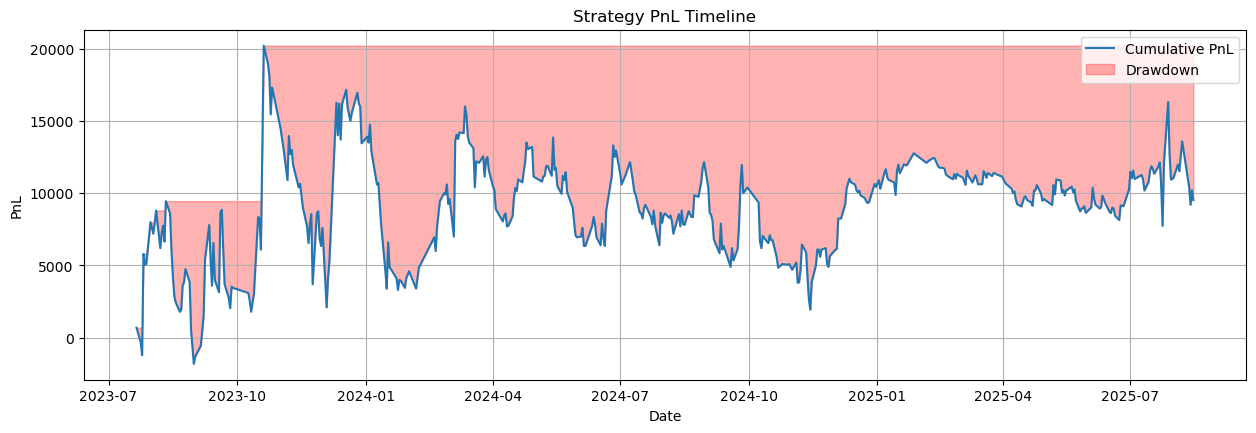




=================  Processing lc_all_ind_3.parquet =================
    open_date open_time  open_price  direction  volume  commission close_date  \
0    20230721  14:17:49    215500.0         -1       1      64.650   20230721   
1    20230724  09:00:02    211600.0         -1       1      63.480   20230724   
2    20230724  14:18:13    210250.0         -1       1      63.075   20230724   
3    20230727  09:05:00    229050.0         -1       1      68.715   20230727   
4    20230728  09:10:00    226450.0          1       1      67.935   20230728   
..        ...       ...         ...        ...     ...         ...        ...   
470  20250808  09:04:03     73920.0          1       1      22.176   20250808   
471  20250812  13:33:50     86800.0          1       1      26.040   20250812   
472  20250813  09:17:03     83080.0         -1       1      24.924   20250813   
473  20250813  10:55:45     84140.0         -1       1      25.242   20250813   
474  20250815  09:10:02     84660.0  

<Figure size 640x480 with 0 Axes>

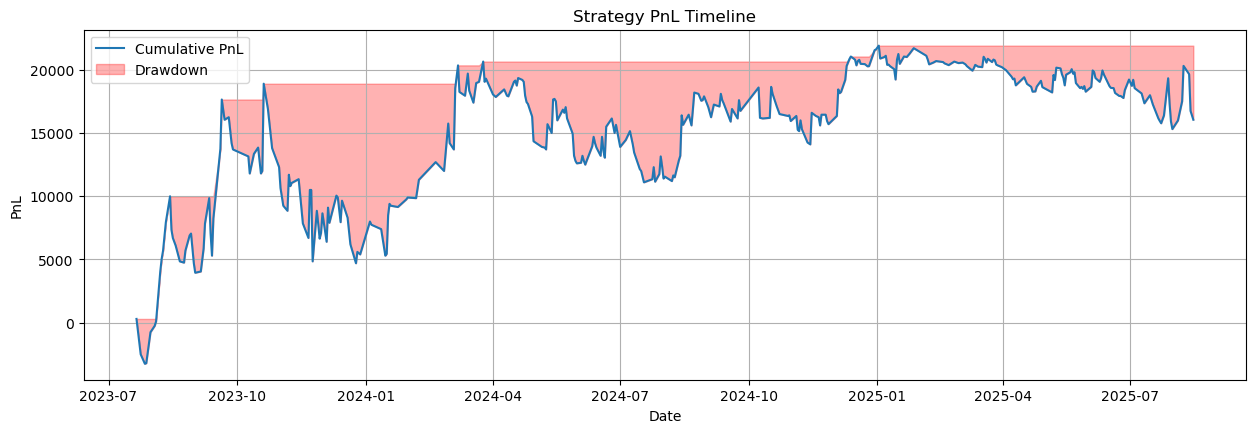

<Figure size 640x480 with 0 Axes>

In [ ]:
import os
comd_list = ['SA','lc'] #'SA','lc'
for comd in comd_list:
    for i in range(1,4):
        print(f"=================  Processing {comd}_all_ind_{i}.parquet =================")
        if os.path.exists(f'C:/Users/CYWY2K/HKUST/STUDY/summer/MAFS6100T/week5/results/2023-2025/{comd}/{comd}_backtest_trades_{i}.csv') and os.path.exists(f'C:/Users/CYWY2K/HKUST/STUDY/summer/MAFS6100T/week5/results/{comd}/{comd}_backtest_metrics_{i}.csv') :
            print(f"File already exists. Skipping computation.")
            continue  # 如果文件已存在，跳过计算

        df = pd.read_parquet(f'C:/Users/CYWY2K/HKUST/STUDY/summer/MAFS6100T/week5/processed_data/2023-2025/{comd}/{comd}_all_ind_{i}.parquet')
        df = df[['trading_date', 'ts', 'lastPrice', 'pos', 'cost']]

        if comd == 'SA': #SA手续费是万二
            metrics, daily_pnl = calculate_backtest_metrics(df, commission_rate=0.0002)
        else: #lc手续费是万1.6
            metrics, daily_pnl = calculate_backtest_metrics(df, commission_rate=0.00016)
        #print(daily_pnl['daily_pnl'])
        print(daily_pnl['trades_df'])
        daily_pnl['trades_df'].to_csv(f'C:/Users/CYWY2K/HKUST/STUDY/summer/MAFS6100T/week5/results/2023-2025/{comd}/{comd}_backtest_trades_{i}.csv', index=False)
        print("=== 回测指标 ===")
        for k, v in metrics.items():
            print(f"{k}: {v:.2f}" if isinstance(v, float) else f"{k}: {v}")
        pd.DataFrame([metrics]).to_csv(f'C:/Users/CYWY2K/HKUST/STUDY/summer/MAFS6100T/week5/results/2023-2025/{comd}/{comd}_backtest_metrics_{i}.csv', index=False)
        plot_backtest_results(daily_pnl,i, comd)
        print("\n\n")

